# Parsing and assembling corpus data for the MSDS 453 final project

This code will take care of bringing in text files, parsing them into tokens, and store the tokenized version of each text together in a dataframe. We'll also include the vectorized version in the same dataframe, just to make things easier

It should also check if a text has already been added, and if it has it will just ignore it.


While in the future we could probably build this to run through a webscraper using Selinium or Scrapy, we're just going to have folks select text documents for now.

### Start by importing everything

In [10]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


import pandas as pd # we'll put things into dataframes, then pickle them
import pickle 
from os import path
import glob

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer

# allow GUI-based document imports
from tkinter import Tk, filedialog
import tkinter as tk

from os import path

import utils

In [2]:
# # download stopwords if necessary
# import nltk
# nltk.download('stopwords')

In [11]:
import ipympl

### Supporting functions

The nice little helpers to get everything running

In [12]:
###############################################################################
### Function to process documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

In [13]:
###############################################################################
#   Functions to label encoding
###############################################################################
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

### Choose files, import

In [14]:
# navigate to the directory we will be scanning
# should be able to do this without using the root...
rt = Tk()
dir_corp = filedialog.askdirectory(master=rt)
rt.destroy()

In [22]:
# load any new files into the "file" pickle
# this is just the title in one column, and all of the cleaned text in the second column

filenames = glob.glob(f"{dir_corp}{path.sep}*.txt")
corp_pkl = path.join(dir_corp,"FileDF.pkl")

if path.exists(corp_pkl):
    with open(corp_pkl,'rb') as fid:
        file_df = pickle.load(fid)
else:
    file_df = pd.DataFrame(columns=['Title','Cleaned_List','Full_Text', 'Publication'])


for filename in filenames:
    with open(filename, 'r', encoding='utf-8') as fid:
        text_block = fid.read()
    
    title = path.splitext(path.split(filename)[-1])[0] # get rid of path and extension info
    if title not in file_df['Title']:
        title_split = title.split('_')
        word_list = clean_doc(text_block) # pull out the individual words, minus stop words etc
        file_dict = {'Title':title, 'Cleaned_List':[word_list], 'Full_Text':[text_block], 'Publication':title_split[-1]}
        file_df = pd.concat([file_df, pd.DataFrame(file_dict)])

# reset the indices
file_df.reset_index(inplace=True, drop=True)

with open(corp_pkl, 'wb') as fid:
    pickle.dump(file_df)

### TFIDF processing

tf-idf using sklearn. 

This is a little more pythonic than the version provided by Paul, but should do all of the same things. Most of the dataframes are named the same, except where I thought a different name might be a little more explanatory

In [9]:
# call the tfidf vectorizer. ngram range allows you to use multi-words within matrix
Tfidf = TfidfVectorizer(ngram_range=(1,3))

# fit with final processed documents
TFIDF_matrix = Tfidf.fit_transform(file_df['word_list'])
TFIDF_df = pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)

# get some summaries
tfidf_mean = np.array(TFIDF_df.mean(axis=0)) # mean tfidf value per term, across documents
tfidf_mean_quarts = np.percentile(tfidf_mean, [25, 75]) # quartiles
cross_doc_outlier = tfidf_mean_quarts[1] + 1.5*(tfidf_mean_quarts[1]-tfidf_mean_quarts[0])

# list of terms that show up frequently
outlier_list = TFIDF_df.columns[tfidf_mean>cross_doc_outlier].to_list()

NameError: name 'TfidfVectorizer' is not defined

### Doc2Vec

using Gensim

In [9]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df = pd.DataFrame([model.infer_vector(txt) for txt in processed_text], index=titles)

### Word2Vec using Gensim

In [10]:
#Note, there are opportunities to use the word2vec matrix to determine words 
#which are similar.  Similar words can be used to create equivalent classes.  
#k-means is not used to group individual words using the Word2Vec output.

#word to vec
model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
w2v_words = list(set([item for sublist in processed_text for item in sublist]))
w2v_words.sort()

# get the w2v vectors in a dictionary, using comprehension
w2v_vectors = {word:model_w2v.wv[word] for ii,word in enumerate(w2v_words) }

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()



## K-means clustering


Using Doc2Vec since everyone else was using tfidf

In [11]:
k= int(np.floor(np.sqrt(len(titles))))
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_df)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

cluster_title = {cluster:titles for cluster,title in enumerate(frame.groupby('Cluster').agg(','.join)['Doc Name'])}


c:\Users\17204\miniconda3\envs\MSDS\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Now plot the clusters


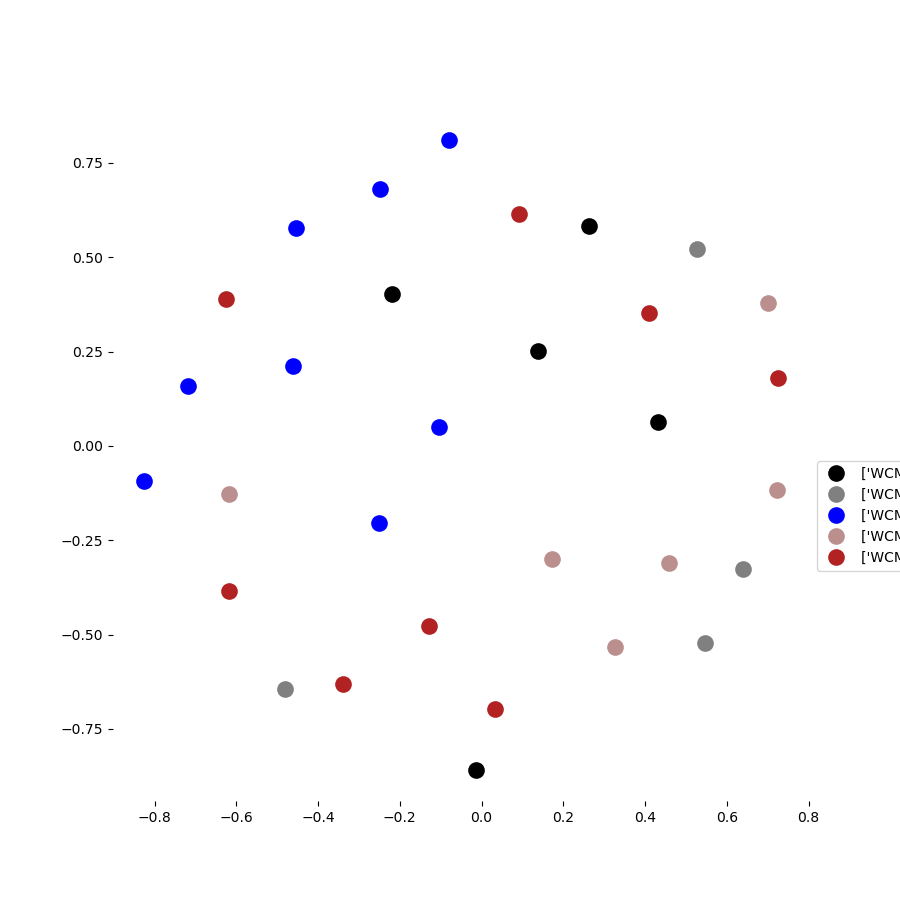

In [21]:
###############################################################################
### Plotting Doc2vec
###############################################################################
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_df)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters_d2v, title=range(0,len(clusters_d2v)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots() # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    # ax.set_aspect('auto')
    # ax.tick_params(\
    #     axis= 'x',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     bottom='off',      # ticks along the bottom edge are off
    #     top='off',         # ticks along the top edge are off
    #     labelbottom='on')
    # ax.tick_params(\
    #     axis= 'y',         # changes apply to the y-axis
    #     which='both',      # both major and minor ticks are affected
    #     left='off',      # ticks along the bottom edge are off
    #     right='off',         # ticks along the top edge are off
    #     labelleft='on')

for spine in ax.spines:
    ax.spines[spine].set_visible(False)


ax.legend(bbox_to_anchor=(1,0.5))      #show legend with only 1 point

fig.set_size_inches([9,9])

fig.savefig('Doc2Vec.png')


In [5]:
path.pathsep

';'

In [8]:
path.sep


'\\'